# Task 2 - clustering and differential expression

In [29]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats

from statsmodels.stats.multitest import fdrcorrection

In [2]:
adata = sc.read('task1_rna_output_linear.h5ad')

In [4]:
sc.tl.leiden(adata)


In [5]:
labels = pd.read_csv('annotation_levels.csv')

In [6]:
coarse_cts = labels['Coarse_annotation_levels'].drop_duplicates().tolist()

In [7]:
coarse_cts

[' Mono',
 ' CD4+ T',
 ' CD8+ T',
 ' NK',
 ' B',
 ' Gamma Delta T',
 ' Cytotoxic CD57+ cells',
 ' MonoDC',
 ' HSPC',
 ' MAIT',
 ' cDC',
 ' pDC']

In [8]:
len(coarse_cts)

12

/home/ssm-user/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


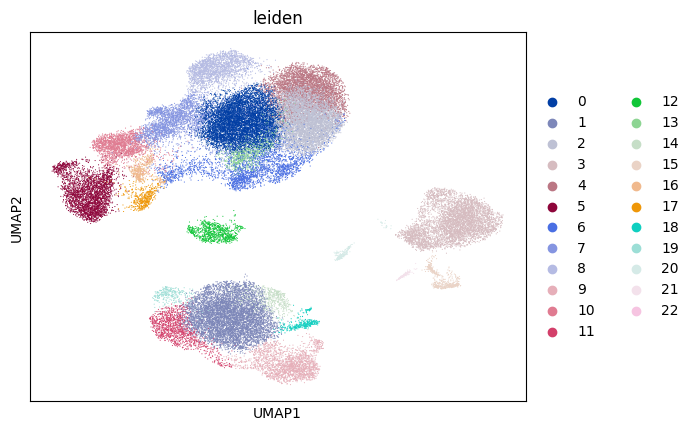

In [9]:
sc.pl.umap(adata, color='leiden')

In [10]:
adata.write('task2_leiden.h5ad')

### Select genes for differential expression

In [11]:
clusters = adata.obs['leiden'].drop_duplicates().tolist()

In [12]:
expressed_genes = []

# For each cluster
for c in clusters:

    # Select cells ct_cells is now a 2d numpy matrix
    ct_cells = adata[adata.obs['leiden'] == c].raw.X.toarray()

    # For each gene, what % of cells have non-zero count
    perc_expr = (ct_cells > 0).mean(axis=0)

    # Is that % we calculated greater than 0.1
    expressed_genes.append( perc_expr > 0.1 )

expressed_genes = np.vstack(expressed_genes).astype(int)

# results in 0 if no cluster expressed that gene over 10% of cells, 1 otherwise
pass_genes = expressed_genes.max(axis=0).astype(bool)

In [13]:
pass_genes.shape

(16524,)

In [14]:
adata.shape

(48518, 1700)

In [30]:
for c in clusters:

    # Select ct and rest cells
    ct_cells = adata.raw[adata.obs['leiden'] == c, pass_genes].X.toarray()
    rest_cells = adata.raw[adata.obs['leiden'] != c, pass_genes].X.toarray()

    # Undo the log1p transformation to get back "raw" "raw" normalized counts that sum to 10K
    ct_cells = np.exp(ct_cells)-1
    rest_cells = np.exp(rest_cells)-1

    # Compute the log fold change across cells (rows)
    lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )

    # Calculate the Wilcoxon rank sum test for each gene
    _, pvalue = stats.ranksums(ct_cells, rest_cells)
    _, fdr = fdrcorrection(pvalue)

    result_df = pd.DataFrame(
        zip(lfc, pvalue),
        index=adata.raw.var.index[pass_genes].tolist(),
        columns=['log2_FC', 'pvalue', 'fdr'])

/tmp/ipykernel_315087/3977080417.py:12: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )


ValueError: 3 columns passed, passed data had 2 columns

In [27]:
result_df

,log2_FC,pvalue
NOC2L,0.477621,5.608887e-18
HES4,6.126266,0.000000e+00
ISG15,1.511801,2.660853e-172
TNFRSF18,-3.880285,8.914892e-02
TNFRSF4,-4.215029,2.599898e-03
...,...,...
MT-ND4L,-0.463811,1.142788e-62
MT-ND4,0.048489,6.413448e-29
MT-ND5,-0.151224,7.309781e-01
MT-ND6,-0.432772,1.329490e-02


In [80]:
_, wilcox_p = stats.wilcoxon(ct_cells, rest_cells, axis=0)

ValueError: The samples x and y must have the same length.

In [74]:
lfc

array([ 0.47762083,  6.12626585,  1.51180082, ..., -0.15122424,
       -0.43277239, -0.47217252])

In [72]:
(np.exp(ct_cells)-1).sum(axis=1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.])

In [ ]:
log_

In [65]:
rest_cells.shape

(46501, 6971)

In [66]:
ct_cells.shape

(2017, 6971)

In [31]:
clusters

['9',
 '2',
 '4',
 '0',
 '14',
 '7',
 '1',
 '5',
 '11',
 '3',
 '6',
 '10',
 '16',
 '13',
 '22',
 '8',
 '19',
 '18',
 '17',
 '21',
 '20',
 '15',
 '12']

In [27]:
adata.uns['log1p']["base"] = None

In [28]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=True)


/home/ssm-user/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/ssm-user/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/ssm-user/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/tools/_rank_gene

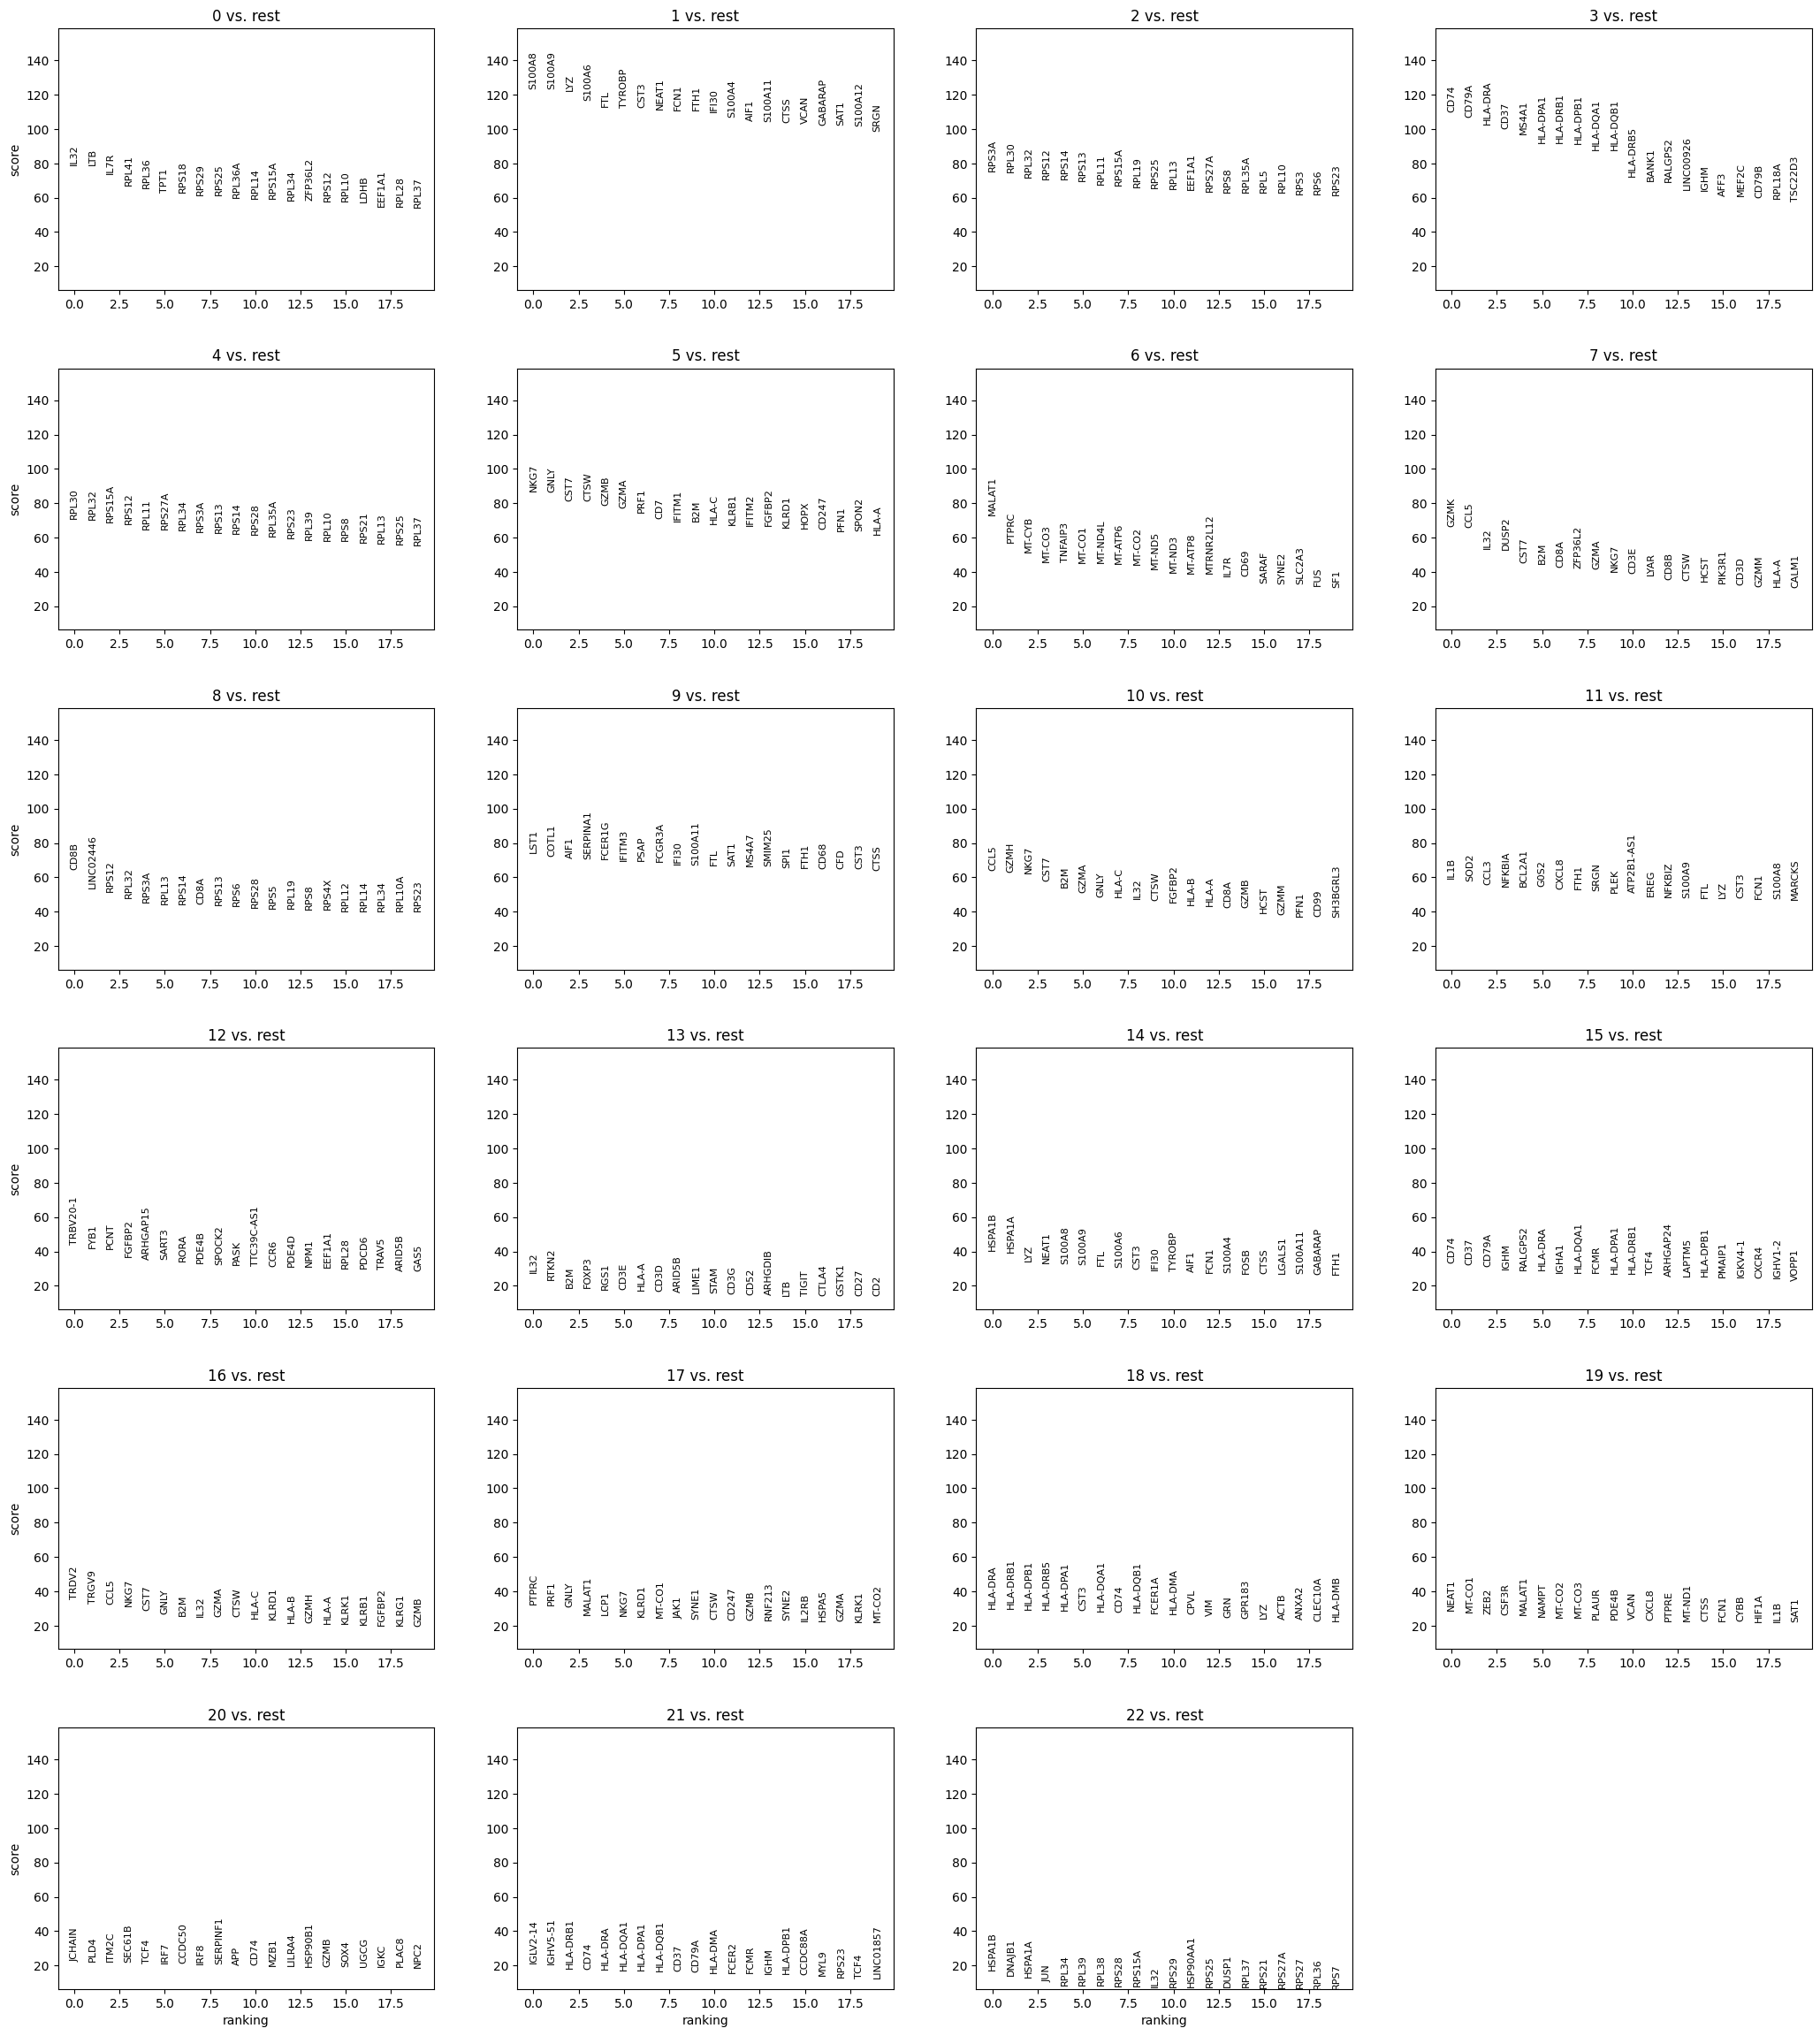

In [29]:
sc.pl.rank_genes_groups(adata)